# VECTORIZING AND MODELING

In [34]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
import pickle
import gc

from tqdm import tqdm
import spacy

In [14]:
df = pd.read_csv('extracted_features.csv', encoding = 'latin-1')
print('Shape of extracted features : ',df.shape)

Shape of extracted features :  (404287, 30)


In [15]:
#Splitting data into 80:20 ratio
cols = [i for i in df.columns if i not in ['qid1','qid2','is_duplicate']]
X = df.loc[:,cols]
Y = df.loc[:,'is_duplicate']
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)
print('Shape of training data : ',x_train.shape)
print('Shape of testing data : ',x_test.shape)

Shape of training data :  (323429, 27)
Shape of testing data :  (80858, 27)


## Tf-IDF weighted W2V

* Finding Tf-IDF scores and converting each question to weighted average of word2vec vectors using the scores. 
* Using pre-trained model GLOVE from spacy (trained on Wikipedia)  
* Use of en_web_core_sm as it is smaller and faster to train  
* Getting IDF value of each word by fitting the Tf-IDF with both question1 and question2  
* If some values of testing data are not iin dictionary of Tf-IDF features, IDF=0 will be returned. 

In [16]:
questions = list(x_train['question1']) + list(x_train['question2'])
tfidf = TfidfVectorizer(lowercase=True)
tfidf.fit(questions)
word_to_idf_score = dict(zip(tfidf.get_feature_names(),tfidf.idf_))
print('Length of features of tf-idf vector : ', len(tfidf.get_feature_names()))

Length of features of tf-idf vector :  79434


In [7]:
#importing en_web_core_sm of 96 dimensions to convert tfidf-w2v for Tf-IDF featurization
try:
    nlp = spacy.load('en_core_web_sm')
except:
    import en_core_web_sm
    nlp = en_core_web_sm.load()

In [19]:
def tfidf_w2v(col):
    vecs1 = []
    for q1 in tqdm(col.values):
        doc1 = nlp(q1)
        mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
        for word1 in doc1:
            vec1 = word1.vector
            try: 
                idf = word_to_idf_score[str(word1)]
            except:
                idf = 0
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)
    return vecs1       

In [10]:
def vectorize_question(col):
    new_df = pd.DataFrame()
    new_df['q'] = tfidf_w2v(col)
    new_df[[i for i in range(96)]] = pd.DataFrame(new_df['q'].values.tolist(), index=new_df.index)
    new_df.drop(['q'],axis=1,inplace=True)
    return new_df

In [17]:
def get_TFIDF_W2V(x_train,x_test):
    if os.path.isfile('tfidf_w2v_q1_train.csv') and os.path.isfile('tfidf_w2v_q2_train.csv'):
        tfidf_w2v_q1_train = pd.read_csv(x_train['question1'])
        tfidf_w2v_q2_train = pd.read_csv(x_train['question2'])
    else:
        tfidf_w2v_q1_train = vectorize_question(x_train['question1'])
        tfidf_w2v_q2_train = vectorize_question(x_train['question2'])
        tfidf_w2v_q1_train.to_csv('tfidf_w2v_q1_train.csv',index=False)
        tfidf_w2v_q2_train.to_csv('tfidf_w2v_q2_train.csv',index=False)
        
    if os.path.isfile('tfidf_w2v_q1_test.csv') and os.path.isfile('tfidf_w2v_q2_test.csv'):
        tfidf_w2v_q1_test = pd.read_csv(x_test['question1'])
        tfidf_w2v_q2_test = pd.read_csv(x_test['question2'])
    else:
        tfidf_w2v_q1_test = vectorize_question(x_test['question1'])
        tfidf_w2v_q2_test = vectorize_question(x_test['question2'])
        tfidf_w2v_q1_test.to_csv('tfidf_w2v_q1_test.csv',index=False)
        tfidf_w2v_q2_test.to_csv('tfidf_w2v_q2_test.csv',index=False)
        
    return tfidf_w2v_q1_train, tfidf_w2v_q2_train, tfidf_w2v_q1_test, tfidf_w2v_q2_test

In [20]:
tfidf_w2v_q1_train, tfidf_w2v_q2_train, tfidf_w2v_q1_test, tfidf_w2v_q2_test = get_TFIDF_W2V(x_train,x_test)
print('Shape of tfidf_w2v_q1_train : ',tfidf_w2v_q1_train.shape)
print('Shape of tfidf_w2v_q2_train : ',tfidf_w2v_q1_train.shape)
print('Shape of tfidf_w2v_q1_test : ',tfidf_w2v_q1_test.shape)
print('Shape of tfidf_w2v_q2_test : ',tfidf_w2v_q1_test.shape)

100%|██████████| 80858/80858 [04:58<00:00, 271.00it/s]


Shape of tfidf_w2v_q1_train :  (323429, 96)
Shape of tfidf_w2v_q2_train :  (323429, 96)
Shape of tfidf_w2v_q1_test :  (80858, 96)
Shape of tfidf_w2v_q2_test :  (80858, 96)


In [21]:
tfidf_w2v_q1_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-3.567588,5.436847,-10.042950,-1.605939,26.186556,31.624662,-0.105194,10.904651,31.006380,-3.671551,...,14.380923,-0.199367,7.218430,4.178157,-22.744829,-14.074194,-7.392252,8.934637,-6.384837,-36.241270
1,13.820792,2.367953,12.312626,6.547846,-15.025793,21.085256,4.878648,5.367686,14.459385,-0.770299,...,9.170911,17.268700,4.848692,18.672208,-8.762614,5.865042,4.516630,2.954625,10.321550,-4.549219


In [23]:
tfidf_w2v_q2_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-27.888781,22.135097,-12.263944,-19.780166,69.759076,91.516912,16.346908,-36.171494,59.140563,-15.350802,...,-23.035960,36.406453,21.599947,-61.690498,-45.920238,5.172481,-13.630391,46.509135,23.217502,-64.450417
1,4.875146,-11.267546,-13.155221,12.092338,-0.057142,4.846013,29.951545,-10.000609,29.205334,-12.927241,...,1.949179,23.165287,17.518953,19.555290,-1.127585,-7.728530,5.187894,9.934342,17.459259,-17.669522


In [24]:
tfidf_w2v_q1_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-9.202248,19.059802,25.598198,21.932832,-13.005902,10.181105,24.045930,-14.899219,14.335820,1.691369,...,47.046812,3.796049,7.857532,0.601657,-15.596641,-21.575635,4.821481,-10.861766,21.274377,-33.630423
1,8.131574,4.961404,-0.707628,14.860166,-7.085104,19.597383,9.660442,9.170387,8.502336,2.437963,...,7.988021,1.863936,18.269946,9.054171,-16.659640,-3.888620,6.560508,-7.861883,2.263233,-4.063256


In [25]:
tfidf_w2v_q2_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-20.742393,20.314899,26.003923,23.029628,-5.143303,12.155519,4.649185,-9.744984,16.667024,-2.203458,...,30.471028,1.555265,-0.511584,1.149208,-5.924932,-20.255796,0.740697,-2.930120,12.585774,-27.360878
1,-1.955206,14.453648,2.076097,12.496927,0.307967,19.462652,3.417498,0.747904,12.910087,-4.504377,...,2.015369,10.267481,13.709572,-8.453676,-8.507495,1.180971,2.962372,0.994019,3.776036,-5.985186


## Tf-IDF Vectors

In [30]:
#splitting train into tfidf_train, tfidf_CV
tfidf_y_test = y_test
tfidf_x_test = x_test
tfidf_x_train, tfidf_cv, tfidf_y_train, tfidf_y_cv = train_test_split(x_train,y_train,test_size=0.2,
                                                        stratify=y_train,random_state=42)
print('Shape of train : ',tfidf_x_train.shape)
print('Shape of cv : ',tfidf_cv.shape)
print('Shape of test : ',tfidf_x_test.shape)

questions = list(tfidf_x_train['question1']) + list(tfidf_x_train['question2'])
tfidf = TfidfVectorizer(max_features=5000,lowercase=True)
tfidf.fit(questions)

tfidf_train_q1, tfidf_train_q2 = tfidf.transform(tfidf_x_train['question1']), tfidf.transform(tfidf_x_train['question2'])
tfidf_cv_q1, tfidf_cv_q2 = tfidf.transform(tfidf_cv['question1']), tfidf.transform(tfidf_cv['question2'])
tfidf_test_q1, tfidf_test_q2 = tfidf.transform(tfidf_x_test['question1']), tfidf.transform(tfidf_x_test['question2'])

Shape of train :  (258743, 27)
Shape of cv :  (64686, 27)
Shape of test :  (80858, 27)


## Merging and Standardizing

* Dropping unwanted columns in train and test  
* We will convert each dataframe into numpy ndarray and merge them into one numpy ndarray using nunmpy hstack() 
* Standardize data using training dataset  
* Splitting X_train again into train and cv dataset  
  
Using only x_train to fit the data and transform both x_train and x_test 

### FOR TF-IDF W2V

In [31]:
cols = [i for i in x_train.columns if i not in ['id', 'qid1', 'qid2','question1', 'question2']]
x_train = x_train.loc[:,cols].values
x_test = x_test.loc[:, cols].values
tfidf_w2v_q1_train, tfidf_w2v_q2_train = tfidf_w2v_q1_train.values, tfidf_w2v_q2_train.values
tfidf_w2v_q1_test, tfidf_w2v_q2_test = tfidf_w2v_q1_test.values, tfidf_w2v_q2_test.values

X_train = np.hstack((x_train, tfidf_w2v_q1_train, tfidf_w2v_q2_train))
X_test = np.hstack((x_test, tfidf_w2v_q1_test, tfidf_w2v_q2_test))

X_train, X_cv , Y_train, Y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state = 42)
std_data1 = StandardScaler()
std_data1.fit(X_train)

X_train = std_data1.transform(X_train)
X_cv = std_data1.transform(X_cv)
X_test = std_data1.transform(X_test)

print('Shape of train : ',X_train.shape)
print('Shape of cv : ',X_cv.shape)
print('Shape of test : ',X_test.shape)

Shape of train :  (258743, 216)
Shape of cv :  (64686, 216)
Shape of test :  (80858, 216)


In [32]:
from scipy.sparse import hstack
tfidf_x_train = hstack((tfidf_train_q1, tfidf_train_q2, tfidf_x_train.iloc[:,3:])).tocsr()
tfidf_x_cv = hstack((tfidf_cv_q1, tfidf_cv_q2, tfidf_cv.iloc[:,3:])).tocsr()
tfidf_x_test = hstack((tfidf_test_q1, tfidf_test_q2, tfidf_x_test.iloc[:,3:])).tocsr()

std_data2 = StandardScaler(with_mean=False)
std_data2.fit(tfidf_x_train)

tfidf_x_train = std_data2.transform(tfidf_x_train)
tfidf_x_cv = std_data2.transform(tfidf_x_cv)
tfidf_x_test = std_data2.transform(tfidf_x_test)

print('Shape of train : ',tfidf_x_train.shape)
print('Shape of cv : ',tfidf_x_cv.shape)
print('Shape of test : ',tfidf_x_test.shape)

Shape of train :  (258743, 10024)
Shape of cv :  (64686, 10024)
Shape of test :  (80858, 10024)


In [38]:
#save the vectorizer and standardizer
with open("std_w2v.pkl", "wb") as f:
    pickle.dump(std_data1, f)

with open("std_tfidf.pkl", "wb") as f:
    pickle.dump(std_data2, f)
    
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("idf_score.pkl", "wb") as f:
    pickle.dump(word_to_idf_score, f)

gc.collect()

0

## Random model for training dataset

In [39]:
def plot_confusion_matrices(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred) #for confusion matrix
    P = C/C.sum(axis = 0)
    R = (C.T/C.sum(axis = 1)).T

    fig = plt.figure(figsize=(18,4))
    
    for i, j in enumerate(zip([C,P,R], ['Confusion', 'Precison', 'Recall'])):
        ax = fig.add_subplot(1,3,i+1)
        if i == 0:
            fmts = 'd'
        else:
            fmts = '0.3f'
        sns.heatmap(j[0], annot = True, fmt = fmts, annot_kws={"size":15})
        plt.xlabel('Predicted Class', fontsize = 12)
        plt.ylabel('Original Class', fontsize = 12)
        plt.title(str(j[1])+' '+'Matrix', fontsize = 15) 
    plt.show()

In [48]:
y_true_cv, y_true_test = Y_cv, y_test
# adding two columns: one for probability of class '0' and for probability of class '1'
# i.e. P(y_train_random_pred[0] == 0), P(y_train_random_pred[1] == 1)
y_cv_random_pred = np.zeros((len(y_true_cv), 2)) 
y_test_random_pred = np.zeros((len(y_true_test), 2)) 

for i in range(len(y_true_cv)):
    random_value = np.random.rand(1,2)
    y_cv_random_pred[i] = (random_value/np.sum(random_value))[0]

for i in range(len(y_true_test)):
    random_value = np.random.rand(1,2)
    y_test_random_pred[i] = (random_value/np.sum(random_value))[0] 

### For training data

Log loss for CV Data using Random Model 0.8927


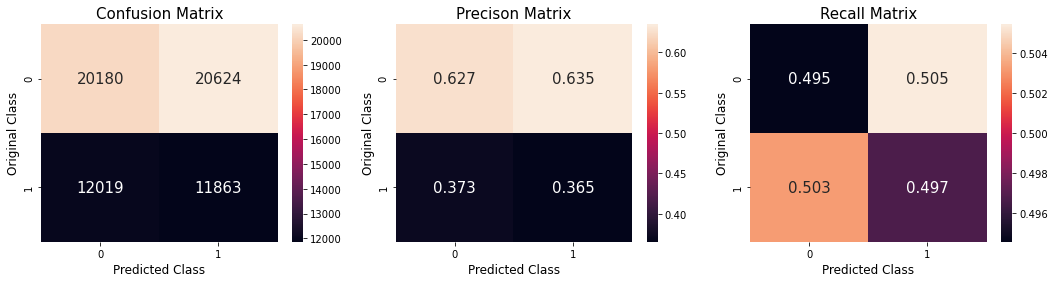

In [49]:
print("Log loss for CV Data using Random Model",round(log_loss(y_true_cv, y_cv_random_pred, eps=1e-15),4))
y_cv_random_pred = np.argmax(y_cv_random_pred, axis = 1) 
plot_confusion_matrices(y_true_cv, y_cv_random_pred)

**Worst log loss value for train data**

### For testing data

Log loss on test Data using Random Model 0.889


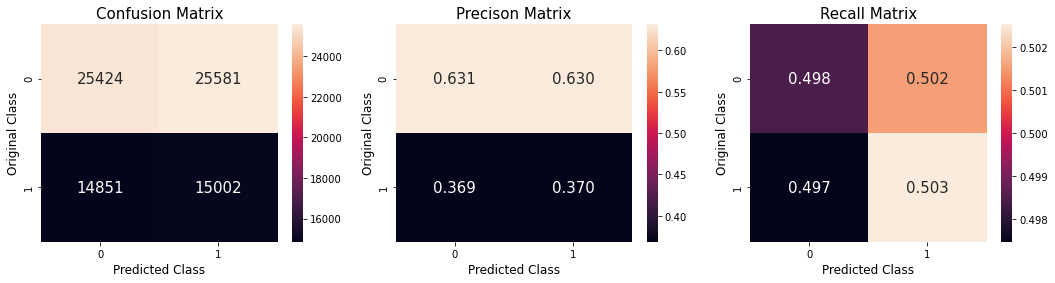

In [50]:
print("Log loss on test Data using Random Model",round(log_loss(y_true_test, y_test_random_pred, eps=1e-15), 4))
y_test_random_pred = np.argmax(y_test_random_pred, axis = 1) 
plot_confusion_matrices(y_true_test, y_test_random_pred)

**Worst log loss value for test data**  
Any reasonable model must have log-loss value in range of (0,0.8927) for train and (0,0.889) for test

## Models

In [51]:
a = Y_train.value_counts()
cl_weight = {0: round(a[1]/(a[0]+a[1]),2), 1: round(a[0]/(a[0]+a[1]), 2)}
cl_weight

{0: 0.37, 1: 0.63}

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import calibration_curve

In [53]:
def plot_log_loss(param, train_auc, cv_auc, hyp_name):
    plt.figure(figsize = (10,6))
    plt.plot(param, train_auc, 'bo:', label = 'Train')
    plt.plot(param, cv_auc, 'ro:', label = 'CV')
    plt.title("log-loss vs hyperparameter '{}' for train and CV".format(hyp_name), fontsize = 15)
    plt.xlabel('hyperparameter '+str(hyp_name), fontsize = 12)
    plt.ylabel('log-loss', fontsize = 12)
    plt.legend()
    plt.grid(1)
    plt.show()

### Logistic Regression (TF-IDF)

In [54]:
log_loss_train = []
log_loss_cv=[]
c = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
for j,i in enumerate(c):
    clf = LogisticRegression(penalty = 'l2', class_weight= cl_weight, C = i, random_state = 42)
    clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    Y_pred_train = calib_clf.predict_proba(tfidf_x_train)
    Y_pred_CV = calib_clf.predict_proba(tfidf_x_cv) 
    
    log_loss_train.append(log_loss(tfidf_y_train, Y_pred_train, labels= calib_clf.classes_, eps=1e-15))
    log_loss_cv.append(log_loss(tfidf_y_cv, Y_pred_CV, labels= calib_clf.classes_, eps=1e-15)) 
    
    print('for C = {} log-loss for train is {} and for CV is {}'.format(i,log_loss_train[j], log_loss_cv[j]))

for C = 0.0001 log-loss for train is 0.3970924491568686 and for CV is 0.4205797519283658
for C = 0.001 log-loss for train is 0.3803338160487314 and for CV is 0.4129128636661642
for C = 0.01 log-loss for train is 0.37700257228126866 and for CV is 0.4121876350201764
for C = 0.1 log-loss for train is 0.377393146105574 and for CV is 0.41308988292521087
for C = 1.0 log-loss for train is 0.37758903594818116 and for CV is 0.41343747120405017
for C = 10.0 log-loss for train is 0.3775520538951489 and for CV is 0.41338712894330104
for C = 100.0 log-loss for train is 0.3775966768281973 and for CV is 0.41348050412465326
for C = 1000.0 log-loss for train is 0.37767769465588574 and for CV is 0.41349488547720226
for C = 10000.0 log-loss for train is 0.37775957199493854 and for CV is 0.41357074649663533


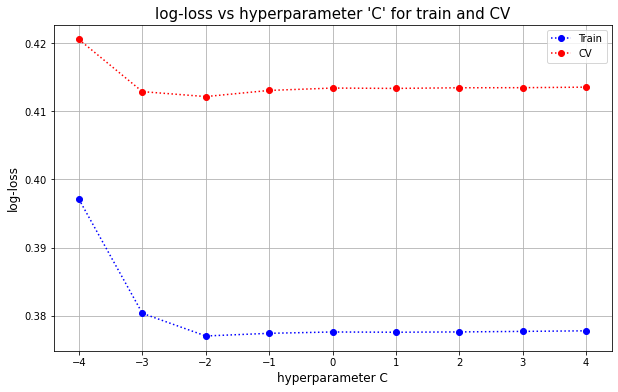

In [55]:
plot_log_loss(np.log10(c), log_loss_train, log_loss_cv, hyp_name = 'C')

In [56]:
LR = LogisticRegression(penalty = 'l2', class_weight= cl_weight, random_state = 42, C = 0.001) #L2 norm
LR.fit(tfidf_x_train, tfidf_y_train.values)
calib_LR = CalibratedClassifierCV(LR, method="sigmoid")
calib_LR.fit(tfidf_x_train, tfidf_y_train.values)
y_prob_train = calib_LR.predict_proba(tfidf_x_train)
y_prob_test = calib_LR.predict_proba(tfidf_x_test)

Log loss on train Data 0.3803


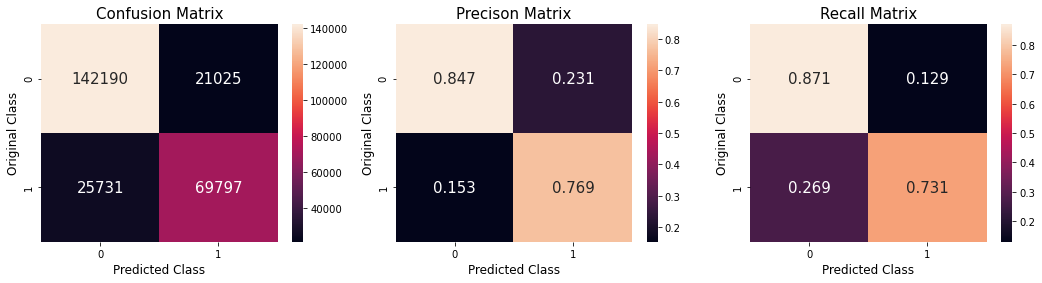

Log loss on test Data 0.4113


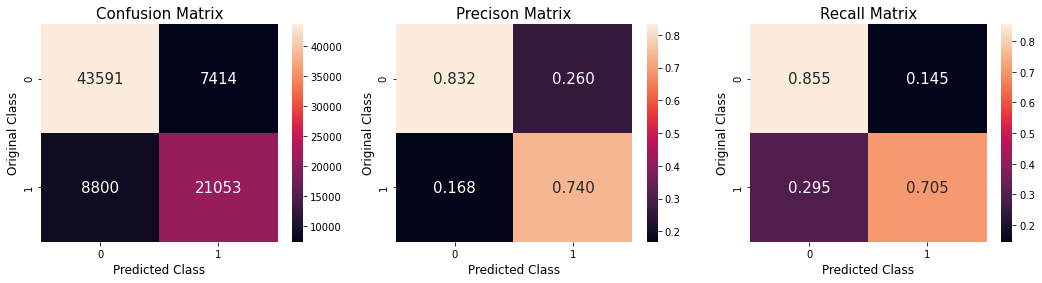

In [57]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) 
plot_confusion_matrices(tfidf_y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) 
plot_confusion_matrices(tfidf_y_test, y_test_pred)

### Logistic Regression(TF-IDF weighted W2V)

In [58]:
log_loss_train = []
log_loss_cv=[]
c = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
for j,i in enumerate(c):
    clf = LogisticRegression(penalty = 'l2', class_weight= cl_weight, C = i, random_state = 42)
    clf.fit(X_train, Y_train.values)
    
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(X_train, Y_train.values)
    
    Y_pred_train = calib_clf.predict_proba(X_train)
    Y_pred_CV = calib_clf.predict_proba(X_cv) 
    
    log_loss_train.append(log_loss(Y_train, Y_pred_train, labels= calib_clf.classes_, eps=1e-15))
    log_loss_cv.append(log_loss(Y_cv, Y_pred_CV, labels= calib_clf.classes_, eps=1e-15)) 
    
    print('for C = {} log-loss for train is {} and for CV is {}'.format(i,log_loss_train[j], log_loss_cv[j]))

for C = 0.0001 log-loss for train is 0.5040225699565569 and for CV is 0.5043769845648564
for C = 0.001 log-loss for train is 0.4865618514618592 and for CV is 0.4872688517304845
for C = 0.01 log-loss for train is 0.48194946930778176 and for CV is 0.4826853223650014
for C = 0.1 log-loss for train is 0.48123932853192697 and for CV is 0.48183692234918607
for C = 1.0 log-loss for train is 0.4812164153759958 and for CV is 0.4817964268916426
for C = 10.0 log-loss for train is 0.48121826655471933 and for CV is 0.48179545200550666
for C = 100.0 log-loss for train is 0.48121659752949264 and for CV is 0.4817948662305519
for C = 1000.0 log-loss for train is 0.48122024199477376 and for CV is 0.4818040331558849
for C = 10000.0 log-loss for train is 0.48121645377783673 and for CV is 0.4817933984874093


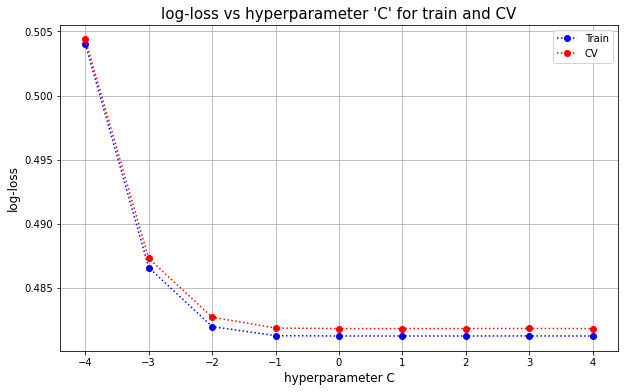

In [59]:
plot_log_loss(np.log10(c), log_loss_train, log_loss_cv, hyp_name = 'C')

In [60]:
LR = LogisticRegression(penalty = 'l2', class_weight= cl_weight, random_state = 42, C = 10**0) #L2 norm
LR.fit(X_train, Y_train)
calib_LR = CalibratedClassifierCV(LR, method="sigmoid")
calib_LR.fit(X_train, Y_train)
y_prob_train = calib_LR.predict_proba(X_train)
y_prob_test = calib_LR.predict_proba(X_test)

Log loss on train Data 0.4812


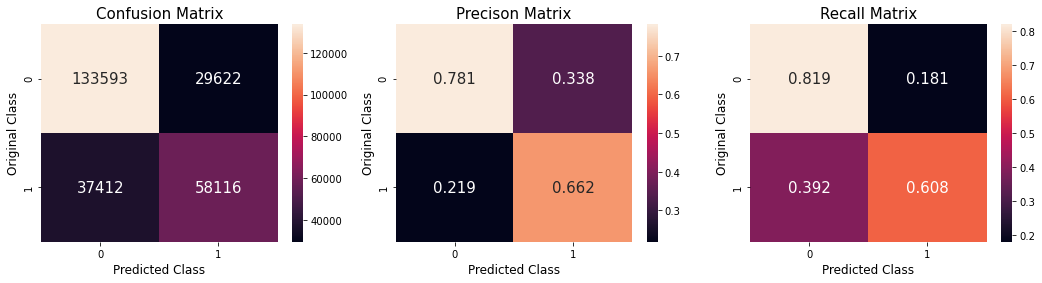

Log loss on test Data 0.4837


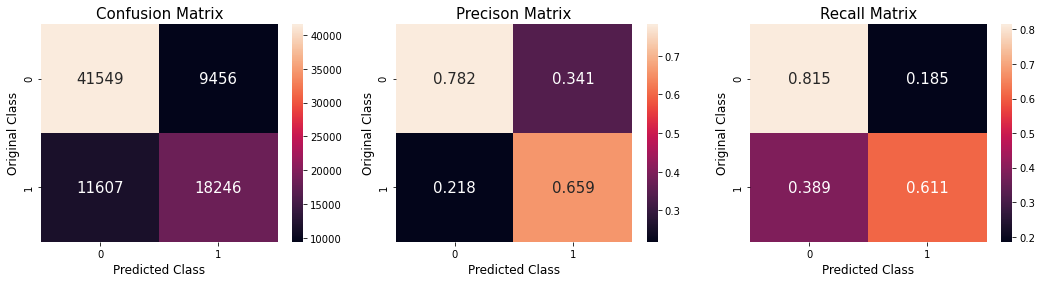

In [61]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) 
plot_confusion_matrices(Y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) 
plot_confusion_matrices(y_test, y_test_pred)

### Linear SVM(TF-IDF)

In [62]:
log_loss_train = []
log_loss_cv=[]
c = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
for j,i in enumerate(c):
    clf = SGDClassifier(alpha = i, penalty='l1', loss='hinge', 
                        class_weight= cl_weight, n_jobs=-1, random_state=42)
    clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(tfidf_x_train, tfidf_y_train.values)
    
    Y_pred_train = calib_clf.predict_proba(tfidf_x_train)
    Y_pred_CV = calib_clf.predict_proba(tfidf_x_cv) 
    
    log_loss_train.append(log_loss(tfidf_y_train, Y_pred_train, labels= calib_clf.classes_, eps=1e-15))
    log_loss_cv.append(log_loss(tfidf_y_cv, Y_pred_CV, labels= calib_clf.classes_, eps=1e-15)) 
    
    print('for C = {} log-loss for train is {} and for CV is {}'.format(i,log_loss_train[j], log_loss_cv[j]))

for C = 0.0001 log-loss for train is 0.6039979147914835 and for CV is 0.6086529601273193
for C = 0.001 log-loss for train is 0.6522683250079055 and for CV is 0.6530838560117703
for C = 0.01 log-loss for train is 0.6582734972097292 and for CV is 0.6583639392117618
for C = 0.1 log-loss for train is 0.6584874928724007 and for CV is 0.658498351794117
for C = 1.0 log-loss for train is 0.6584769782425505 and for CV is 0.6584786081026179
for C = 10.0 log-loss for train is 0.6584826384793414 and for CV is 0.6584767754728664
for C = 100.0 log-loss for train is 0.6585287087463999 and for CV is 0.6585279444319946
for C = 1000.0 log-loss for train is 0.6585287087463999 and for CV is 0.6585279444319946
for C = 10000.0 log-loss for train is 0.6585287087463999 and for CV is 0.6585279444319946


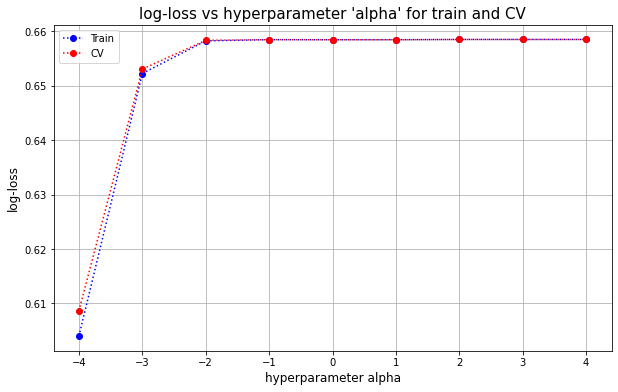

In [63]:
plot_log_loss(np.log10(c), log_loss_train, log_loss_cv, hyp_name = 'alpha')

In [64]:
SVM = SGDClassifier(alpha = 10**-4, penalty='l1', loss='hinge', 
                    class_weight= cl_weight, n_jobs=-1, random_state=42) #L2 norm
SVM.fit(tfidf_x_train, tfidf_y_train.values)
calib_LR = CalibratedClassifierCV(SVM, method="sigmoid")
calib_LR.fit(tfidf_x_train, tfidf_y_train.values)
y_prob_train = calib_LR.predict_proba(tfidf_x_train)
y_prob_test = calib_LR.predict_proba(tfidf_x_test)


Log loss on train Data 0.604


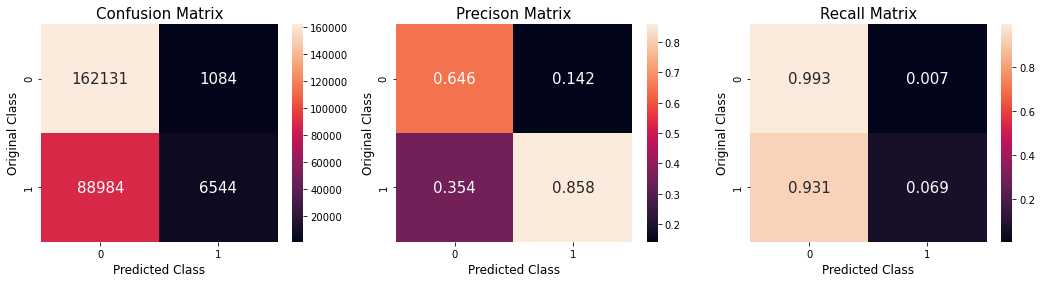

Log loss on test Data 0.6081


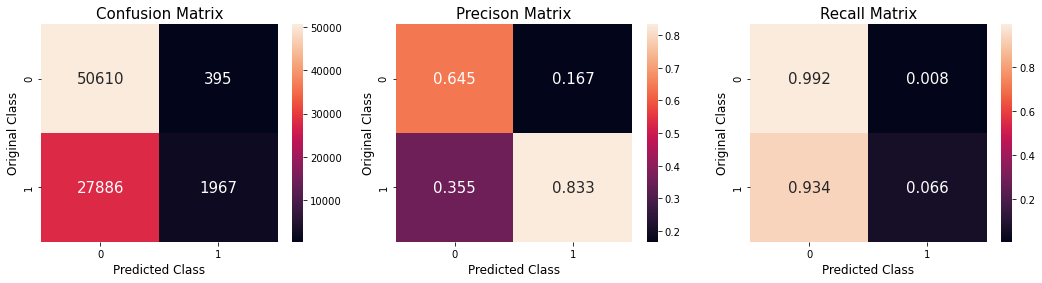

In [65]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) 
plot_confusion_matrices(tfidf_y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) 
plot_confusion_matrices(tfidf_y_test, y_test_pred)

### Linear SVM(TF-IDF Weighted W2V)

In [66]:
log_loss_train = []
log_loss_cv=[]
c = np.array([10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4])
for j,i in enumerate(c):
    clf = SGDClassifier(alpha = i, penalty='l1', loss='hinge', 
                        class_weight= cl_weight, n_jobs=-1, random_state=42)
    clf.fit(X_train, Y_train.values)
    
    calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
    calib_clf.fit(X_train, Y_train.values)
    
    Y_pred_train = calib_clf.predict_proba(X_train)
    Y_pred_CV = calib_clf.predict_proba(X_cv) 
    
    log_loss_train.append(log_loss(Y_train, Y_pred_train, labels= calib_clf.classes_, eps=1e-15))
    log_loss_cv.append(log_loss(Y_cv, Y_pred_CV, labels= calib_clf.classes_, eps=1e-15)) 
    
    print('for alpha = {}: log-loss of train is {} and of CV is {}'.format(i,log_loss_train[j], log_loss_cv[j]))

for alpha = 0.0001: log-loss of train is 0.48369862319516405 and of CV is 0.48466238564282654
for alpha = 0.001: log-loss of train is 0.486879222104088 and of CV is 0.4877195533788593
for alpha = 0.01: log-loss of train is 0.5131974008680137 and of CV is 0.5136730542352083
for alpha = 0.1: log-loss of train is 0.5398653514648764 and of CV is 0.5418131692134696
for alpha = 1.0: log-loss of train is 0.6585287087463998 and of CV is 0.6585279444319944
for alpha = 10.0: log-loss of train is 0.6585287087463998 and of CV is 0.6585279444320074
for alpha = 100.0: log-loss of train is 0.6585287087463997 and of CV is 0.6585279444319944
for alpha = 1000.0: log-loss of train is 0.6585287087463998 and of CV is 0.6585279444319946
for alpha = 10000.0: log-loss of train is 0.6585287087463999 and of CV is 0.6585279444319946


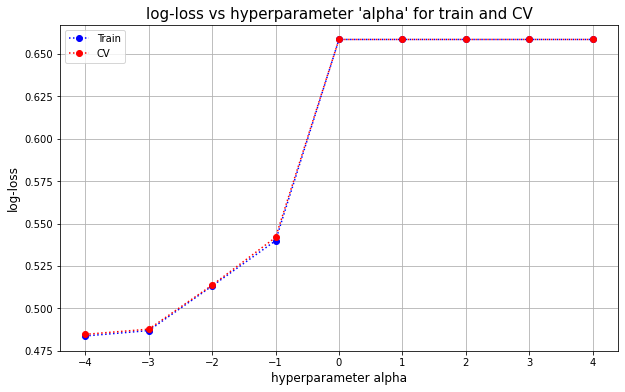

In [67]:
plot_log_loss(np.log10(c), log_loss_train, log_loss_cv, hyp_name = 'alpha')

In [68]:
SVM = SGDClassifier(alpha = 10**-4, penalty='l1', loss='hinge', 
                    class_weight= cl_weight, n_jobs=-1, random_state=42) 
SVM.fit(X_train, Y_train.values)
calib_LR = CalibratedClassifierCV(SVM, method="sigmoid")
calib_LR.fit(X_train, Y_train.values)
y_prob_train = calib_LR.predict_proba(X_train)
y_prob_test = calib_LR.predict_proba(X_test)

Log loss on train Data 0.4837


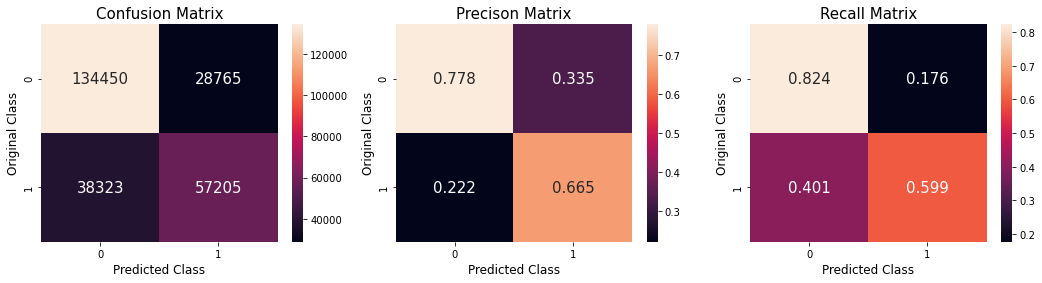

Log loss on test Data 0.486


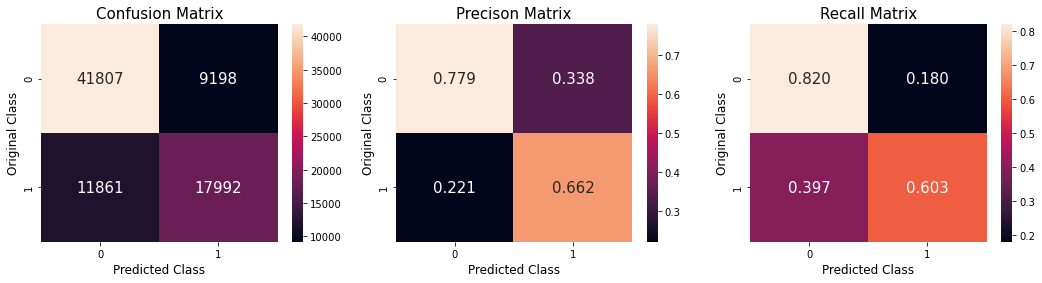

In [69]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) 
plot_confusion_matrices(Y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) 
plot_confusion_matrices(y_test, y_test_pred)

### GBDT (TF-IDF)

In [70]:
estimators = np.array([10, 50, 100, 200, 400, 500]) 
depths = np.array( [2, 4, 6, 8, 10])#

try:
    train_log_loss1 = pd.read_csv('xgb_light_train.csv')
    train_log_loss1.index, train_log_loss1.columns  = estimators, depths 
    cv_log_loss1 = pd.read_csv('xgb_light_cv.csv')
    cv_log_loss1.index, cv_log_loss1.columns = estimators, depths
except:
    train_log_loss1 = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    cv_log_loss1    = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    
print('{} pairs are left to be check to tune the hyperparamter:'.format((cv_log_loss1 == 0).values.sum()))

for est in estimators:
    for depth in depths:
        if train_log_loss1.loc[est,depth] == 0 and cv_log_loss1.loc[est,depth] == 0: 
            print('Training and calibrating for: n_estimators = {}, max_depth = {}'.format(est, depth))
           
            
            XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = depth, n_estimators= est, class_weight = cl_weight)
            XGB.fit(tfidf_x_train, tfidf_y_train.values)

            calib_clf = CalibratedClassifierCV(XGB, method="sigmoid")
            calib_clf.fit(tfidf_x_train, tfidf_y_train.values)

            Y_pred_train = calib_clf.predict_proba(tfidf_x_train)
            Y_pred_CV = calib_clf.predict_proba(tfidf_x_cv)
            
            # finding the log-loss value
            train_log_loss1.loc[est,depth] = np.round(log_loss(tfidf_y_train, Y_pred_train, labels = XGB.classes_, eps=1e-15),4)
            cv_log_loss1.loc[est,depth] = np.round(log_loss(tfidf_y_cv, Y_pred_CV, labels= XGB.classes_, eps=1e-15),4)
            
            # save the value in each iteration
            train_log_loss1.to_csv('xgb_light_train.csv', index=False)
            cv_log_loss1.to_csv('xgb_light_cv.csv', index=False)

30 pairs are left to be check to tune the hyperparamter:
Training and calibrating for: n_estimators = 10, max_depth = 2
Training and calibrating for: n_estimators = 10, max_depth = 4
Training and calibrating for: n_estimators = 10, max_depth = 6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training and calibrating for: n_estimators = 10, max_depth = 8
[LightGBM] [Warning] Accuracy may be bad 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training and calibrating for: n_estimators = 200, max_depth = 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training and calibrating for: n_estimators = 400, max_depth = 2
Training and calibrating for: n_estimators = 400, max_depth = 4
Training and calibrating fo

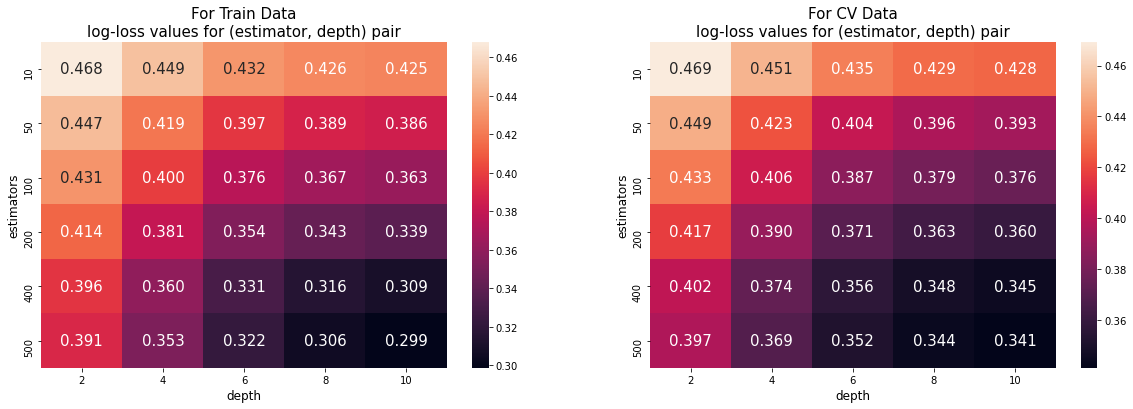

In [71]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.heatmap(train_log_loss1, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For Train Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)  

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.heatmap(cv_log_loss1, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For CV Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)
plt.show()

**From above heatmap of log-loss for different pairs of estimators, estimator 500 and depth 10 is giving least log-loss of 0.299 for training and 0.341 for testing**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


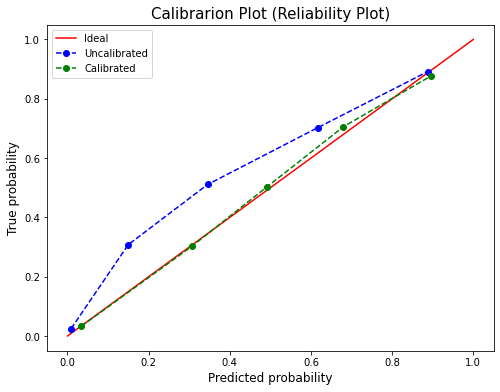

In [72]:
if os.path.isfile('tfidf_GBDT_model.pkl'):
    with open('tfidf_GBDT_model.pkl', 'rb') as f:
        calib_gbdt_tfidf = pickle.load(f)
else:
    XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = 10, n_estimators= 500, 
                         class_weight = cl_weight, random_state=42) 
    XGB.fit(tfidf_x_train, tfidf_y_train.values)
    calib_gbdt_tfidf = CalibratedClassifierCV(XGB, method="sigmoid")
    calib_gbdt_tfidf.fit(tfidf_x_train, tfidf_y_train.values)
    
    #save the model
    with open('tfidf_GBDT_model.pkl', 'wb') as f:
        pickle.dump(calib_gbdt_tfidf, f)

#let's whether it needs calibration or not
true_uncalib, pred_uncalib = calibration_curve(tfidf_y_test, XGB.predict_proba(tfidf_x_test)[:,1])
true_calib, pred_calib = calibration_curve(tfidf_y_test, calib_gbdt_tfidf.predict_proba(tfidf_x_test)[:,1])

#let's plot them:
plt.figure(figsize = (8,6))
plt.plot([0,1], [0,1], 'r-', label = 'Ideal')
plt.plot(true_uncalib, pred_uncalib, 'bo--', label = 'Uncalibrated')
plt.plot(true_calib, pred_calib, 'go--', label = 'Calibrated')
plt.title('Calibrarion Plot (Reliability Plot)', fontsize = 15)
plt.xlabel('Predicted probability', fontsize = 12)
plt.ylabel('True probability', fontsize = 12)
plt.legend()
plt.show()

Log loss on train Data 0.2988


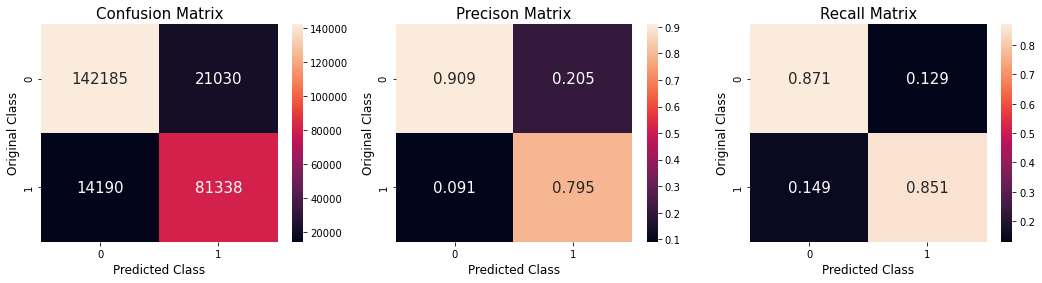

Log loss on test Data 0.3415


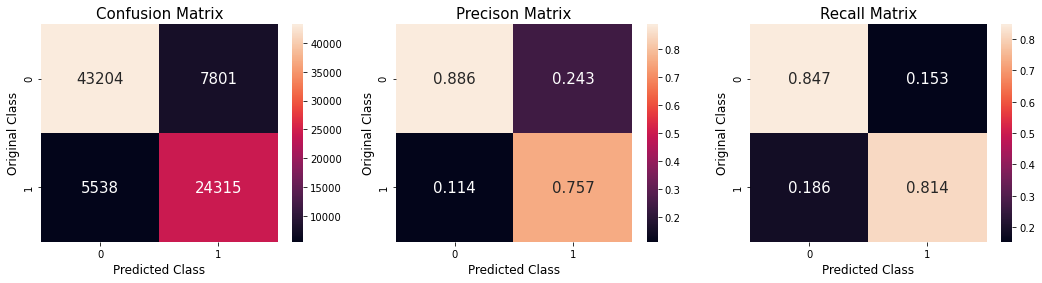

In [73]:
y_prob_train = calib_gbdt_tfidf.predict_proba(tfidf_x_train)
y_prob_test = calib_gbdt_tfidf.predict_proba(tfidf_x_test)
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) 
plot_confusion_matrices(tfidf_y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) 
plot_confusion_matrices(tfidf_y_test, y_test_pred)

###  GBDT(TF-IDF Weighted W2V)

In [74]:
estimators = np.array([10, 50, 100, 200, 400, 500]) #estimators
depths = np.array( [2, 4, 6, 8, 10])#

try:
    train_log_loss = pd.read_csv('xgb_light_train5.csv')

    train_log_loss.index, train_log_loss.columns  = estimators, depths 
    cv_log_loss = pd.read_csv('xgb_light_cv5.csv')
    cv_log_loss.index, cv_log_loss.columns = estimators, depths
except:
    train_log_loss = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    cv_log_loss    = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    
print('{} pairs are left to be check to tune the hyperparamter:'.format((cv_log_loss == 0).values.sum()))

for est in estimators:
    for depth in depths:
        if train_log_loss.loc[est,depth] == 0 and cv_log_loss.loc[est,depth] == 0: 
            print('Training and calibrating for: n_estimators = {}, max_depth = {}'.format(est, depth))
           
            XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = depth, n_estimators= est, class_weight = cl_weight)
            XGB.fit(X_train, Y_train.values)

            calib_clf = CalibratedClassifierCV(XGB, method="sigmoid")
            calib_clf.fit(X_train, Y_train.values)

            Y_pred_train = calib_clf.predict_proba(X_train)
            Y_pred_CV = calib_clf.predict_proba(X_cv)
            
            # finding the log-loss value
            train_log_loss.loc[est,depth] = np.round(log_loss(Y_train, Y_pred_train, labels = XGB.classes_, eps=1e-15),4)
            cv_log_loss.loc[est,depth] = np.round(log_loss(Y_cv, Y_pred_CV, labels= XGB.classes_, eps=1e-15),4)
            
            # save the value in each iteration
            train_log_loss.to_csv('xgb_light_train5.csv', index=False)
            cv_log_loss.to_csv('xgb_light_cv5.csv', index=False)
            

30 pairs are left to be check to tune the hyperparamter:
Training and calibrating for: n_estimators = 10, max_depth = 2
Training and calibrating for: n_estimators = 10, max_depth = 4
Training and calibrating for: n_estimators = 10, max_depth = 6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training and calibrating for: n_estimators = 10, max_depth = 8
[LightGBM] [Warning] Accuracy may be bad 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training and calibrating for: n_estimators = 200, max_depth = 10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training and calibrating for: n_estimators = 400, max_depth = 2
Training and calibrating for: n_estimators = 400, max_depth = 4
Training and calibrating fo

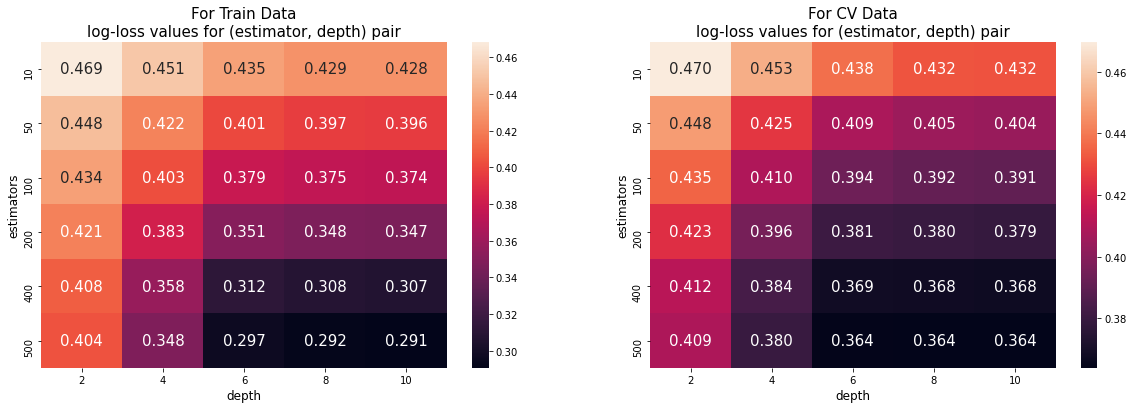

In [75]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.heatmap(train_log_loss, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For Train Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)  

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.heatmap(cv_log_loss, annot = True, fmt = '0.3f', annot_kws={"size":15})
plt.ylabel('estimators', fontsize = 12)
plt.xlabel('depth', fontsize = 12)
plt.title('For CV Data\nlog-loss values for (estimator, depth) pair', fontsize = 15)
plt.show()

In [76]:
if os.path.isfile('tfidf_w2v_GBDT_model.pkl'):
    with open('tfidf_w2v_GBDT_model.pkl', 'rb') as f:
        calib_gbdt_tfidf_w2v = pickle.load(f)
else:
    XGB = LGBMClassifier(boosting_type = 'gbdt', max_depth = 6, n_estimators= 500, 
                         class_weight = cl_weight, random_state=42) 
    XGB.fit(X_train, Y_train.values)
    calib_gbdt_tfidf_w2v = CalibratedClassifierCV(XGB, method="sigmoid")
    calib_gbdt_tfidf_w2v.fit(X_train, Y_train.values)
    
    #save the model
    with open('tfidf_w2v_GBDT_model.pkl', 'wb') as f:
        pickle.dump(calib_gbdt_tfidf_w2v, f)
        
y_prob_train = calib_gbdt_tfidf_w2v.predict_proba(X_train)
y_prob_test = calib_gbdt_tfidf_w2v.predict_proba(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Log loss on train Data 0.2963


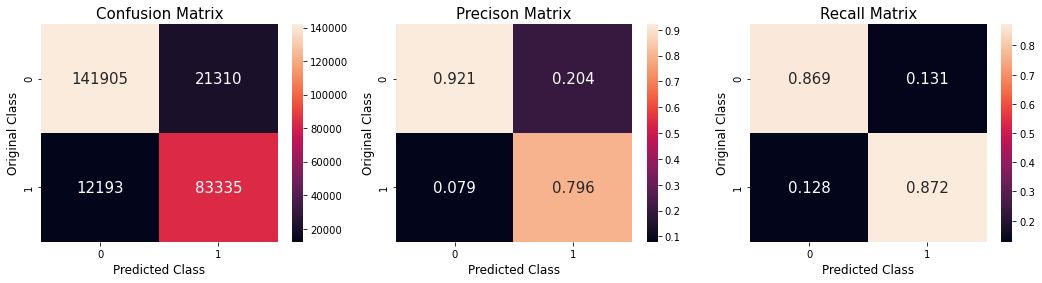

Log loss on test Data 0.3676


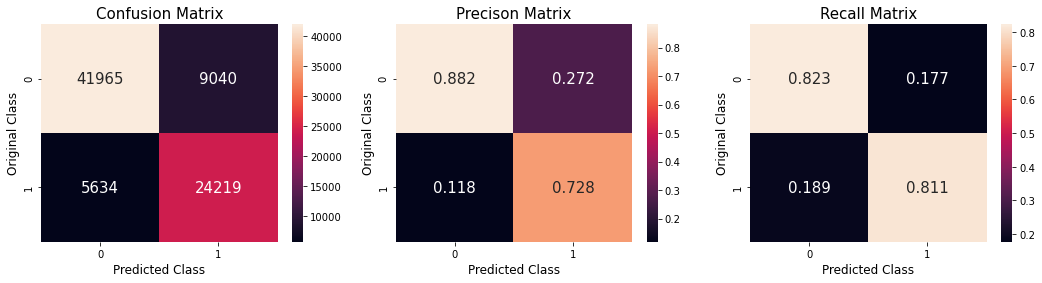

In [77]:
print("Log loss on train Data",round(log_loss(Y_train, y_prob_train, eps=1e-15),4))
y_train_pred = np.argmax(y_prob_train, axis = 1) 
plot_confusion_matrices(Y_train, y_train_pred)

print("Log loss on test Data",round(log_loss(y_test, y_prob_test, eps=1e-15),4))
y_test_pred = np.argmax(y_prob_test, axis = 1) 
plot_confusion_matrices(y_test, y_test_pred)

## Conclusion:

* After TFIDF and TFIDF-W2V vectorization, the best model is GBDT with TFIDF vectors giving test log-loss of 0.3415  
* Second best model is GBDT with TFIDF-W2V vectors giving test log-loss of 0.3676

In [79]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "hyperparameter", "Train Log-Loss", "Test Log-Loss"]
x.add_row(['Random Model', 'None', 0.8927 , 0.889])
x.add_row(['Logistic Regression (TFIDF)', 'C = 0.001', 0.3803, 0.4113])
x.add_row(['Logistic Regression (TFIDF-W2V)', 'C = 1', 0.4812, 0.4837])
x.add_row(['Linear SVM (TFIDF)', 'alpha = 10**-4',0.604, 0.6081])
x.add_row(['Linear SVM (TFIDF-W2V)', 'alpha = 10**-4', 0.4837, 0.486])
x.add_row(['GBDT (TFIDF)', 'depth = 10, estimators = 500', 0.2988, 0.3415])
x.add_row(['GBDT (TFIDF-W2V)', 'depth = 8, estimators = 500', 0.2963, 0.3676])
print(x)

+---------------------------------+------------------------------+----------------+---------------+
|              Model              |        hyperparameter        | Train Log-Loss | Test Log-Loss |
+---------------------------------+------------------------------+----------------+---------------+
|           Random Model          |             None             |     0.8927     |     0.889     |
|   Logistic Regression (TFIDF)   |          C = 0.001           |     0.3803     |     0.4113    |
| Logistic Regression (TFIDF-W2V) |            C = 1             |     0.4812     |     0.4837    |
|        Linear SVM (TFIDF)       |        alpha = 10**-4        |     0.604      |     0.6081    |
|      Linear SVM (TFIDF-W2V)     |        alpha = 10**-4        |     0.4837     |     0.486     |
|           GBDT (TFIDF)          | depth = 10, estimators = 500 |     0.2988     |     0.3415    |
|         GBDT (TFIDF-W2V)        | depth = 8, estimators = 500  |     0.2963     |     0.3676    |
